<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [5]:
import torch

import matplotlib.pyplot as plt

import cv2
import numpy as np

import laia.common.logging as log
from laia.common.arguments import add_argument, args, add_defaults
from laia.common.arguments_types import str2bool
from laia.common.loader import ModelLoader, CheckpointLoader
from laia.data import ImageDataLoader, ImageFromListDataset
from laia.decoders import CTCGreedyDecoder
from laia.engine.feeders import ImageFeeder, ItemFeeder
from laia.experiments import Experiment
from laia.utils import SymbolsTable, ImageToTensor
from laia.data import ImageDataLoader, TextImageFromTextTableDataset
import laia.data.transforms as transforms
import multiprocessing
from laia.engine.feeders import ImageFeeder, ItemFeeder
import pickle
import pandas as pd
import os

from tqdm.notebook import tqdm

import editdistance

def compute_cdist(gt, pred):
    return editdistance.eval(gt, pred), len(gt)

def compute_wdist(gt, pred):
    return compute_cdist(chars2words(gt), chars2words(pred))

def compute_cer(gt, pred):
    return editdistance.eval(gt, pred)/len(gt)

def chars2words(chars):
    return "".join(chars).split('@') if isinstance(chars, list) else ""

def compute_wer(gt, pred):
    return compute_cer(chars2words(gt), chars2words(pred))

In [22]:
syms = SymbolsTable('../exper/puigcerver17_bn_dist/train/syms_ctc.txt')
device = torch.device('cuda:0')

train_path = '../exper/puigcerver17_bn_dist/train/'
model_filename = 'model'
checkpoint_filename = 'experiment.ckpt.lowest-valid-cer-54'
gt_path = '../data/lang/puigcerver/lines/char/te.txt'
image_path = '../data/imgs/lines_h128'

In [23]:
model = ModelLoader(
        train_path, filename=model_filename, device=device
    ).load()
state = CheckpointLoader(device=device).load_by(
        os.path.join(train_path, checkpoint_filename)
    )
if 'tr_engine' in state:
    state = Experiment.get_model_state_dict(state)
model.load_state_dict(state)
model = model.to(device)
model.eval()

LaiaCRNN(
  (conv): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Leak

In [25]:
dataset = TextImageFromTextTableDataset(
    gt_path,
    image_path,
    img_transform=ImageToTensor(),
    txt_transform=transforms.text.ToTensor(syms),
)
dataset_loader = ImageDataLoader(
    dataset=dataset,
    image_channels=1,
    batch_size=10,
    num_workers=8,
)
batch_input_fn = ImageFeeder(device=device, parent_feeder=ItemFeeder("img"))
batch_target_fn = ItemFeeder("txt")
batch_id_fn = ItemFeeder("id")
decoder = CTCGreedyDecoder()


In [27]:
decoded = []
target = []
ids = []

counter = 0

# Go through all the samples, compute the prediction, get the label
for batch in dataset_loader:

    batch_input = batch_input_fn(batch)
    batch_target = batch_target_fn(batch)
    batch_id = batch_id_fn(batch)

    batch_input = batch_input_fn(batch)
    batch_output = model(batch_input)
    batch_decoded = decoder(batch_output)

    decoded.extend(batch_decoded)
    target.extend(batch_target)
    ids.extend(batch_id)

In [28]:
decoded = [[syms[char] for char in entry] for entry in decoded]
target = [[syms[char] if char else "?" for char in entry] for entry in target]
result = pd.DataFrame(zip(ids, target, decoded), columns=['id', 'target', 'decoded']).set_index('id')
result['cer'] = result.apply(lambda row: compute_cer(row['target'], row['decoded']), axis=1)
result['wer'] = result.apply(lambda row: compute_wer(row['target'], row['decoded']), axis=1)
result[['cdist', 'clen']] = result.apply(lambda row: compute_cdist(row['target'], row['decoded']), result_type='expand', axis=1)
result[['wdist', 'wlen']] = result.apply(lambda row: compute_wdist(row['target'], row['decoded']), result_type='expand', axis=1)


In [29]:
result['cdist'].sum()/result['clen'].sum(), result['wdist'].sum()/result['wlen'].sum()

(0.07155720592219549, 0.2279736536226269)

In [30]:
result[['cer', 'wer']].describe()

,cer,wer
count,2915.000000,2915.000000
mean,0.072414,0.232289
std,0.081544,0.208586
min,0.000000,0.000000
25%,0.019608,0.090909
50%,0.050000,0.200000
75%,0.100000,0.333333
max,1.000000,3.000000


In [31]:
def res2clean(res):
    return "".join(res).replace('@', ' ')
def show_result(result_row):
    img_path = os.path.join(image_path, result_row.name + ".jpg")
    target = res2clean(result_row['target'])
    decoded = res2clean(result_row['decoded'])
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.imread(img_path)[:,:,::-1])
    print(f'Target was "{target}", prediction is "{decoded}"')

Target was "he shrugged diffidently , " I like the work . One gets plenty", prediction is "H AuCE DOTECIDOTTUD , " I LIKE THE wOek . One a# pra"


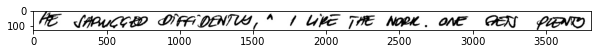

In [32]:
show_result(result.loc[result['cer'] > 0.6].sample(1).iloc[0])

In [34]:
result.loc[result['cer'] > 0]

,target,decoded,cer,wer,cdist,clen,wdist,wlen
id,,,,,,,,
c04-110-03,"[C, H, R, I, S, @, C, H, A, R, L, E, S, @, ,, ...","[C, H, R, I, S, @, C, H, R, R, L, E, S, @, ,, ...",0.070423,0.357143,5,71,5,14
c04-116-00,"[H, e, @, i, s, @, a, l, s, o, @, a, @, d, i, ...","[H, e, @, i, s, @, a, l, s, o, @, a, @, d, i, ...",0.011628,0.047619,1,86,1,21
c04-116-02,"[T, o, l, c, h, @, ,, @, a, s, @, h, e, @, i, ...","[T, o, l, c, h, @, ,, @, a, s, @, h, e, @, i, ...",0.044444,0.181818,4,90,4,22
c04-116-01,"[w, r, i, t, e, r, @, ., @, H, e, @, w, r, i, ...","[w, r, i, t, e, r, @, ., @, H, e, @, w, r, i, ...",0.010989,0.050000,1,91,1,20
c04-110-00,"[B, e, c, o, m, e, @, a, @, s, u, c, c, e, s, ...","[B, e, c, o, m, e, @, a, @, s, u, c, c, e, s, ...",0.048780,0.166667,4,82,3,18
...,...,...,...,...,...,...,...,...
r03-053-07,"[c, l, i, e, n, t, ', s, @, e, y, e, s, @, ,, ...","[c, l, i, e, n, t, s, @, e, y, e, s, @, ,, @, ...",0.086957,0.400000,4,46,4,10
r03-053-06,"[p, u, r, p, o, s, e, @, t, h, a, n, @, t, h, ...","[p, u, s, p, o, s, e, @, M, e, n, @, t, h, e, ...",0.325000,0.625000,13,40,5,8
r03-053-08,"[t, h, e, @, f, a, k, e, @, f, r, i, e, n, d, ...","[H, e, @, f, r, e, k, e, @, f, r, i, e, n, d, ...",0.175000,0.555556,7,40,5,9


In [36]:
result.loc[result['cer'] > 0].describe()

,cer,wer,cdist,clen,wdist,wlen
count,2283.000000,2283.000000,2283.000000,2283.000000,2283.000000,2283.000000
mean,0.092460,0.296593,3.933421,43.755585,2.577311,9.034604
std,0.081466,0.190990,3.801372,10.781017,1.742029,2.686698
min,0.010989,0.047619,1.000000,5.000000,1.000000,1.000000
25%,0.039216,0.142857,2.000000,38.000000,1.000000,7.000000
50%,0.069767,0.250000,3.000000,43.000000,2.000000,9.000000
75%,0.118846,0.400000,5.000000,50.000000,3.000000,11.000000
max,1.000000,3.000000,53.000000,93.000000,14.000000,22.000000


In [35]:
result[result['cer'] ==0]

,target,decoded,cer,wer,cdist,clen,wdist,wlen
id,,,,,,,,
c04-165-03,"[o, f, @, a, n, @, A, m, e, r, i, c, a, n, @, ...","[o, f, @, a, n, @, A, m, e, r, i, c, a, n, @, ...",0.0,0.0,0,48,0,10
c04-165-06,"[T, h, e, @, f, i, l, m, @, c, o, v, e, r, e, ...","[T, h, e, @, f, i, l, m, @, c, o, v, e, r, e, ...",0.0,0.0,0,45,0,9
c04-165-05,"[D, e, n, n, i, s, @, B, r, o, g, a, n, @, ,, ...","[D, e, n, n, i, s, @, B, r, o, g, a, n, @, ,, ...",0.0,0.0,0,53,0,10
c04-170-02,"[t, o, @, m, a, k, e, @, t, h, e, @, s, t, r, ...","[t, o, @, m, a, k, e, @, t, h, e, @, s, t, r, ...",0.0,0.0,0,42,0,8
c04-165-08,"[t, o, @, t, h, e, @, E, u, r, o, p, e, a, n, ...","[t, o, @, t, h, e, @, E, u, r, o, p, e, a, n, ...",0.0,0.0,0,31,0,6
...,...,...,...,...,...,...,...,...
p06-058-03,"[k, n, o, w, @, t, h, a, t, @, w, e, l, l, @, ...","[k, n, o, w, @, t, h, a, t, @, w, e, l, l, @, ...",0.0,0.0,0,25,0,6
p06-058-08,"[a, @, h, a, n, d, @, a, n, d, @, g, r, a, s, ...","[a, @, h, a, n, d, @, a, n, d, @, g, r, a, s, ...",0.0,0.0,0,25,0,6
p06-096-02,"[o, r, i, g, i, n, @, o, f, @, h, e, r, @, r, ...","[o, r, i, g, i, n, @, o, f, @, h, e, r, @, r, ...",0.0,0.0,0,40,0,8


In [50]:
idx = 0

Target was "CHRIS CHARLES , 39 , who lives in Stockton-on-Tees , is an accountant .", prediction is "CHRIS CHRRLES , 39 , who lives in Stocuton-on - Tees , is an accounlant ."


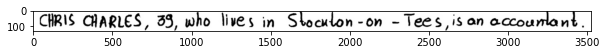

In [51]:
show_result(result.loc[result['cer'] > 0].iloc[idx])
idx += 1

- Evalutation par écriture.
- Ne pas enlever le background -> pour ne pas fausser la layout.
- Enlever les parties imprimées.

In [47]:
with open('../data/lang/all/lines/char.txt', 'r') as infile:
    lines = infile.readlines()

data = [(x.strip().split()[0], x.strip().split()[1:]) for x in lines]

from collections import Counter

char_counter = Counter()
for _, chars in data:
    char_counter.update(chars)

char_counter

Counter({'A': 1257,
         '@': 101587,
         'M': 1144,
         'O': 469,
         'V': 171,
         'E': 675,
         't': 39972,
         'o': 33343,
         's': 27867,
         'p': 8253,
         'r': 27516,
         '.': 6224,
         'G': 661,
         'a': 35849,
         'i': 30300,
         'k': 2819,
         'e': 56911,
         'l': 18036,
         'f': 10006,
         'm': 10642,
         'n': 31027,
         'g': 8653,
         'y': 8264,
         'L': 638,
         'b': 6803,
         'u': 12203,
         'P': 722,
         'd': 17952,
         'w': 8808,
         'c': 11823,
         'h': 25244,
         'F': 489,
         'j': 423,
         'W': 728,
         ',': 5629,
         'x': 785,
         '0': 431,
         'T': 1652,
         '-': 1545,
         "'": 1987,
         'v': 4528,
         'B': 854,
         'H': 988,
         '"': 1629,
         'S': 1064,
         '1': 494,
         '9': 179,
         '5': 157,
         '8': 118,
         '3': 174,
 